**Mounting the Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading Library**

In [2]:
import numpy as np
import os
import cv2
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pickle
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


**Image Loading to Create Dataset**

In [3]:
# Function for loading and augmenting images
def load_and_augment_images(image_folder, label_value, augmentation_params, num_augmented_samples):
    images = [img for img in os.listdir(image_directory + image_folder) if img.endswith('.png')]
    for image_name in images:
        image = cv2.imread(os.path.join(image_directory, image_folder, image_name))
        if image is not None:
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            image = np.array(image)

            # Augmentation
            image_datagen = ImageDataGenerator(**augmentation_params)
            image = np.expand_dims(image, axis=0)
            augmented_images = [next(image_datagen.flow(image, batch_size=1))[0].astype(np.uint8) for _ in range(num_augmented_samples)]
            for augmented_image in augmented_images:
                dataset.append(augmented_image)
                label.append(label_value)

In [4]:
# Defining variables and parameters
image_directory = "/content/drive/MyDrive/Dataset_BUSI_with_GT/"
SIZE = 128
dataset = []
label = []
NUM_AUGMENTED_SAMPLES = 5  # Number of augmented samples per image

# Load and augment images for each class
load_and_augment_images('benign/', 0, augmentation_params={}, num_augmented_samples=NUM_AUGMENTED_SAMPLES)
load_and_augment_images('malignant/', 1, augmentation_params={'horizontal_flip': True, 'rotation_range': 30, 'brightness_range': [0.8, 1.2], 'zoom_range': 0.2}, num_augmented_samples=NUM_AUGMENTED_SAMPLES)
load_and_augment_images('normal/', 2, augmentation_params={}, num_augmented_samples=NUM_AUGMENTED_SAMPLES)

**Random Forest Model**

In [5]:
# Convert dataset and label to numpy arrays
dataset = np.array(dataset)
label = np.array(label)
print("Dataset shape:", dataset.shape)
print("Label shape:", label.shape)

# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.15, random_state=42)

Dataset shape: (7890, 128, 128, 3)
Label shape: (7890,)


In [6]:
num_samples_train, height_train, width_train, channels_train = X_train.shape
X_train_reshaped = X_train.reshape(num_samples_train, height_train * width_train * channels_train)

# Define and train the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
model.fit(X_train_reshaped, y_train)


RandomForestClassifier(random_state=42)

In [7]:
num_samples_test, height_test, width_test, channels_test = X_test.shape
X_test_reshaped = X_test.reshape(num_samples_test, height_test * width_test * channels_test)

# Evaluate the model
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_reshaped)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       689
           1       1.00      0.92      0.96       300
           2       0.99      1.00      1.00       195

    accuracy                           0.98      1184
   macro avg       0.99      0.97      0.98      1184
weighted avg       0.98      0.98      0.98      1184



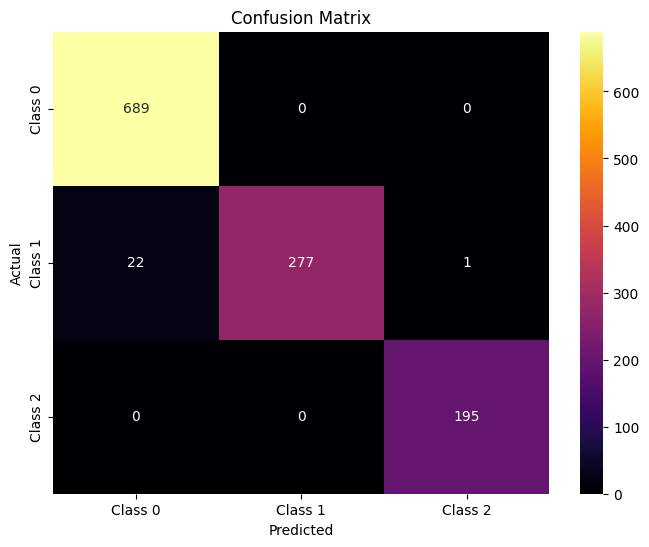

In [8]:
# Visualize the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

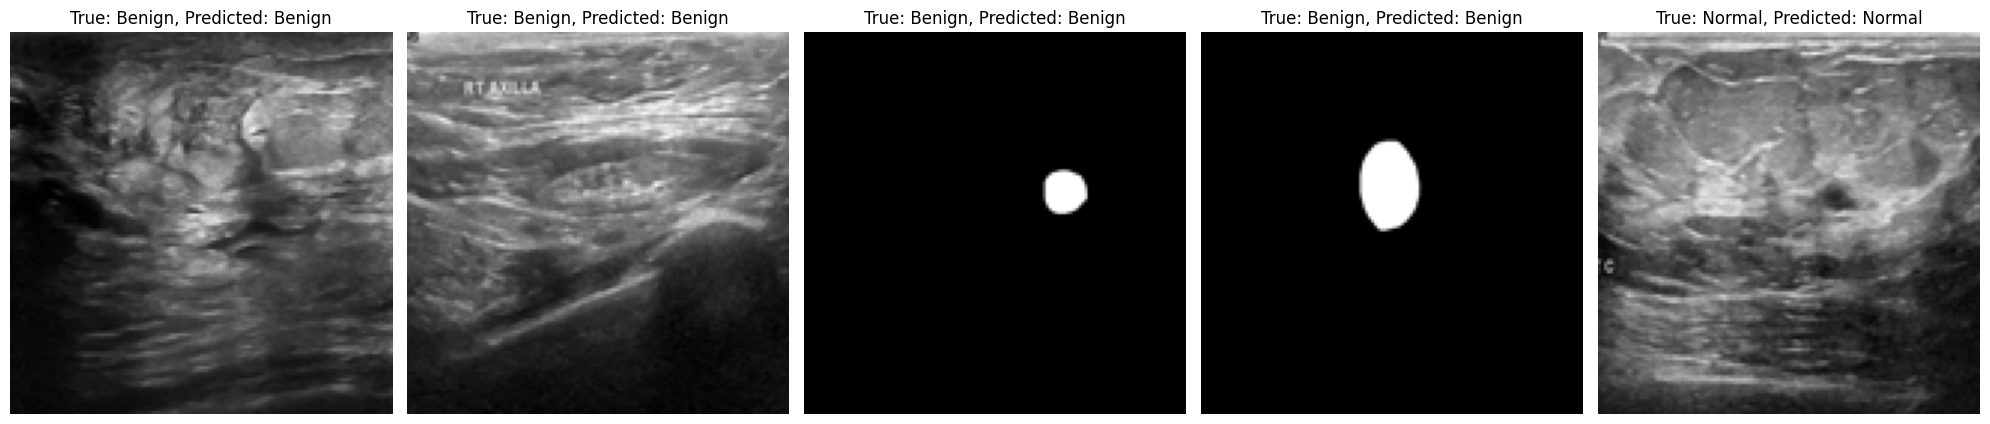

In [9]:
# Display a subset of images from the test set
label_dict = {0: 'Benign', 1: 'Malignant', 2: 'Normal'}
num_samples_to_display = 5
random_indices = np.random.choice(X_test_reshaped.shape[0], num_samples_to_display, replace=False)
images = X_test_reshaped[random_indices]
true_labels = y_test[random_indices]
predicted_labels = model.predict(images)
true_labels = [label_dict[x] for x in true_labels]
predicted_labels = [label_dict[x] for x in predicted_labels]
plt.figure(figsize=(20, 5))
for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(images[i].reshape(SIZE, SIZE, 3))
    plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_reshaped, y_train)
pickle.dump(rf_model, open('rf_model.pkl', 'wb'))

**SVM Model**

In [11]:

# Create SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Train model
svm_model.fit(X_train_reshaped, y_train)

# Evaluate model on test set
svm_predictions = svm_model.predict(X_test_reshaped)


print(classification_report(y_test, svm_predictions))
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       689
           1       1.00      0.79      0.88       300
           2       0.96      1.00      0.98       195

    accuracy                           0.95      1184
   macro avg       0.96      0.93      0.94      1184
weighted avg       0.95      0.95      0.95      1184

SVM Accuracy: 0.9476351351351351


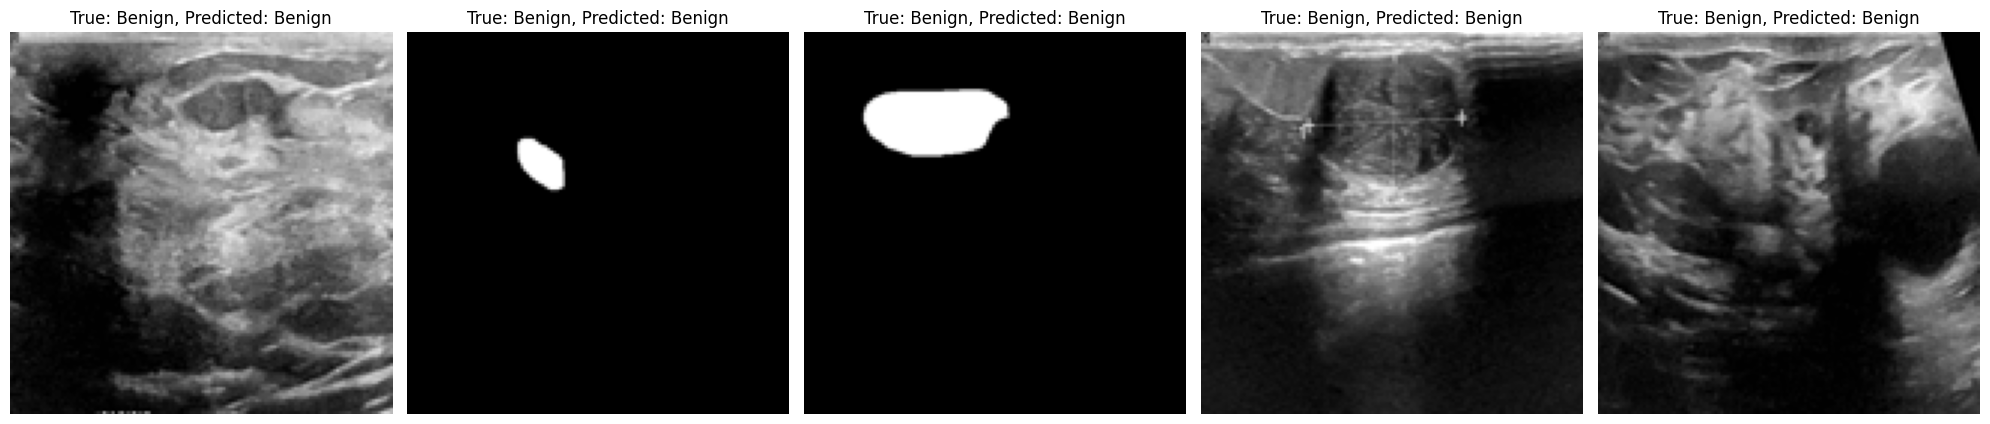

In [12]:
# Display a subset of images from the test set with SVM predictions
num_samples_to_display = 5
random_indices = np.random.choice(X_test_reshaped.shape[0], num_samples_to_display, replace=False)
images = X_test_reshaped[random_indices]
true_labels = y_test[random_indices]

# Predict labels for the sample images
svm_predictions = svm_model.predict(images)

# Map label indices to actual strings
true_labels = [label_dict[x] for x in true_labels]
predicted_labels = [label_dict[x] for x in svm_predictions]

# Display the images and labels with predictions
plt.figure(figsize=(20, 5))
for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(images[i].reshape(SIZE, SIZE, 3))
    plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [13]:
pickle.dump(svm_model, open('svm_model.pkl', 'wb'))

**ResNet Model**

In [14]:
# Dataset parameters
img_height = 128
img_width = 128
num_channels = 3
num_classes = 3

In [15]:
# Reshape data to match image shape
X_train_reshaped = X_train_reshaped.reshape(-1, img_height, img_width, num_channels)
X_test_reshaped = X_test_reshaped.reshape(-1, img_height, img_width, num_channels)

In [16]:
# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [17]:
# Create ResNet model
resnet_base = ResNet50(weights=None, include_top=False, input_shape=(img_height, img_width, num_channels))

x = resnet_base.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=resnet_base.input, outputs=predictions)

In [18]:
# Compile and train model
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
model.fit(X_train_reshaped, y_train, epochs=10)

Epoch 1/10
210/210 [==============================] - 67s 128ms/step - loss: 6.9872 - accuracy: 0.5489
Epoch 2/10
210/210 [==============================] - 25s 118ms/step - loss: 1.3865 - accuracy: 0.6391
Epoch 3/10
210/210 [==============================] - 25s 120ms/step - loss: 0.7310 - accuracy: 0.7416
Epoch 4/10
210/210 [==============================] - 26s 122ms/step - loss: 0.5388 - accuracy: 0.7897
Epoch 5/10
210/210 [==============================] - 26s 122ms/step - loss: 0.3603 - accuracy: 0.8527
Epoch 6/10
210/210 [==============================] - 26s 121ms/step - loss: 0.2760 - accuracy: 0.8914
Epoch 7/10
210/210 [==============================] - 26s 122ms/step - loss: 0.2057 - accuracy: 0.9229
Epoch 8/10
210/210 [==============================] - 26s 122ms/step - loss: 0.2691 - accuracy: 0.8932
Epoch 9/10
210/210 [==============================] - 26s 122ms/step - loss: 0.1669 - accuracy: 0.9344
Epoch 10/10
210/210 [==============================] - 26s 122ms/step - l

37/37 [==============================] - 2s 34ms/step


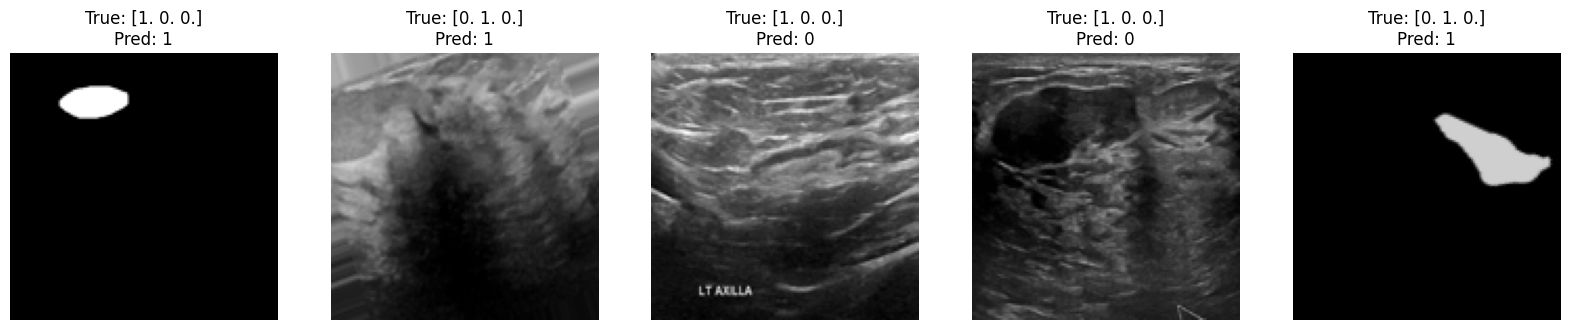

In [19]:

# Evaluate on test set
model.evaluate(X_test_reshaped, y_test)

# Make predictions on test set
y_pred = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred, axis=1)

# Display few predictions
num_samples = 5
plt.figure(figsize=(20, 10))
for i in range(num_samples):
  ax = plt.subplot(1, num_samples, i+1)
  plt.imshow(X_test[i].reshape(img_height, img_width, num_channels))
  plt.title("True: "+ str(y_test[i]) +
             "\nPred: "+ str(y_pred[i]))
  plt.axis('off')
plt.show()

In [20]:



# Evaluate the model on the test data using `evaluate`
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)

# Print the accuracy
print('\nTest accuracy:', test_acc)

# Get predictions from the model using `predict`
predictions = model.predict(X_test_reshaped)

# Print the first 5 predictions
print(predictions[0:5])

# Calculate the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

# Print the confusion matrix
print(cm)

# Calculate the classification report
classification_report = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1))

# Print the classification report
print(classification_report)


37/37 - 1s - loss: 1.7317 - accuracy: 0.6833 - 1s/epoch - 34ms/step

Test accuracy: 0.6832770109176636
37/37 [==============================] - 1s 31ms/step
[[2.85063356e-01 7.14935124e-01 1.51840527e-06]
 [7.05681834e-03 9.92943108e-01 4.01930211e-10]
 [9.98653769e-01 1.34608592e-03 1.49707859e-07]
 [9.97216702e-01 2.59779138e-03 1.85436016e-04]
 [1.29010035e-02 9.87098992e-01 7.83325488e-12]]
[[418 271   0]
 [ 19 280   1]
 [ 84   0 111]]
              precision    recall  f1-score   support

           0       0.80      0.61      0.69       689
           1       0.51      0.93      0.66       300
           2       0.99      0.57      0.72       195

    accuracy                           0.68      1184
   macro avg       0.77      0.70      0.69      1184
weighted avg       0.76      0.68      0.69      1184

